In [1]:
%pip install -q -U segmentation-models-pytorch
%pip install torch_xla -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, cv2, gc, glob
import numpy as np
import pandas as pd
import random, tqdm
from PIL import Image
import seaborn as sns
import torch
#import torch_xla
#import torch_xla.core.xla_model as xm
import torch.nn as nn
import albumentations as album
from tqdm import tqdm_notebook
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as ssmp_utils
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None
EPOCHS=8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
display(DEVICE)
ROOT_DIR = '../input/geonrw/data'
TRAIN_DIRS = ['aachen', 'bergisch', 'bielefeld',
              'bochum', 'bonn','wuppertal','solingen','siegen','remscheid'
              ,'paderborn','oberhausen','neuss','muenster','muelheim',
             'moenchengladbach','lippstadt','lippetal','leverkusen','krefeld',
             'borken','bottrop','coesfeld','dortmund','dueren','duesseldorf'
              ,'erftstadt','essen','euskirchen','gelsenkirchen','guetersloh',
             'hamm','heinsberg','herford','herne','hoexter']
VALID_DIRS = ['duisburg', 'lotte','recklinghausen','moers','koeln','ennepetal','hagen','kleve']
CLASSES = ['unknown', 'forest', 'water', 'agricultural', 'urban', 'grassland', 'railway', 'highway', 'airports_shipyards', 'roads', 'buildings']
COLORS  = ['#2ca02c', '#1f77b4', '#8c564b', '#7f7f7f', '#bcbd22', '#ff7f0e', '#9467bd', '#17becf', '#d62728', '#e377c2']
LCOV_CMAP = matplotlib.colors.ListedColormap(COLORS)
LCOV_NORM = matplotlib.colors.Normalize(vmin=1, vmax=10)

'cuda'

The `get_data` function takes in two parameters, `root` and `dirs`. It initializes an empty list called `paths`. Then, it iterates over each element in the `dirs` list using a for loop. Within the loop, it uses the `glob.glob` function to find all file paths that match the pattern `'{os.path.join(root, image_dir)}/*rgb.jp2'`. The `os.path.join` function is used to concatenate the `root` and `image_dir` paths. The `glob.glob` function returns a list of file paths that match the pattern. The `extend` method is used to add these file paths to the `paths` list. Finally, the function returns a new list comprehension that replaces the 'rgb.jp2' extension with an empty string for each path in the `paths` list.

The `to_tensor` function takes in a parameter `x` and any additional keyword arguments. It returns the transpose of `x` with dimensions rearranged to (2, 0, 1) and casted to the data type 'float32'. The `transpose` method is called on `x` with the arguments (2, 0, 1) to rearrange the dimensions. The `astype` method is used to cast the resulting array to the 'float32' data type. The function also accepts any additional keyword arguments, but they are not used in the code snippet.

The `seg2rgb` function takes in a parameter `seg_map`. It applies two functions, `LCOV_NORM` and `LCOV_CMAP`, to `seg_map`. The result is then sliced to only include the first three channels using `[:, :, :3]`. The function returns the resulting segmented RGB map. The specific implementations of `LCOV_NORM` and `LCOV_CMAP` are not provided in the code snippet.

In [4]:
def get_data(root, dirs):
    paths = []
    for image_dir in dirs:
        paths.extend(glob.glob(f'{os.path.join(root, image_dir)}/*rgb.jp2'))
    return [path.replace('rgb.jp2', '') for path in paths]

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def seg2rgb(seg_map):
    return LCOV_CMAP(LCOV_NORM(seg_map))[:, :, :3]

The `__init__` method initializes the dataset by taking a list of file paths as input. It creates two lists: `image_paths` and `mask_paths`. The `image_paths` list is created by appending the string `'rgb.jp2'` to each path in the input list. Similarly, the `mask_paths` list is created by appending the string `'seg.tif'` to each path in the input list. The `classes` variable is set to the value of the `CLASSES` constant. The `transforms` parameter is also stored as an attribute of the class.

The `__getitem__` method is responsible for retrieving a specific item from the dataset. It takes an index `idx` as input and opens the image and mask files corresponding to that index using the `Image.open` function from the PIL library. The image is then converted to the RGB color mode using the `convert` method. The image and mask are then converted to NumPy arrays using the `np.array` function. The mask array is then expanded along the third dimension using the `np.newaxis` attribute to match the dimensions of the image array.

If the `transforms` attribute is not `None`, the `transforms` function is applied to the image and mask arrays using the `sample` dictionary. The transformed image and mask arrays are then assigned back to the `image` and `mask` variables.

Finally, the method returns the image and mask arrays, with the mask array cast to the `long` data type.

The `__len__` method returns the length of the dataset, which is equal to the length of the `image_paths` list.

In [5]:
class LandMarkDataset(Dataset):
    def __init__(self, paths, transforms=None):
        self.image_paths = [f'{path}rgb.jp2' for path in paths]
        self.mask_paths = [f'{path}seg.tif' for path in paths]
        self.classes = CLASSES
        self.transforms = transforms

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])
        
        image, mask = np.array(image), np.array(mask)
        mask = mask[:, :, np.newaxis]

        if self.transforms:
            sample = self.transforms(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask.astype('long')

    def __len__(self):
        return len(self.image_paths)

This code is initializing a model for semantic segmentation using the DeepLabV3Plus architecture. 

The `model` variable is created using the `smp.DeepLabV3Plus` class, which takes several parameters:
- `encoder_name`: the name of the encoder architecture to use. This determines the backbone of the model.
- `encoder_weights`: the weights to use for the encoder. These weights are typically pre-trained on a large dataset.
- `in_channels`: the number of input channels for the model. In this case, it is set to 3, indicating RGB images.
- `activation`: the activation function to use in the model. This determines the non-linearity of the model.
- `classes`: the number of classes to predict. This determines the number of output channels in the final layer of the model.

The `loss` variable is created using the `smp.losses.DiceLoss` class, which calculates the Dice loss for multi-class segmentation. The `mode` parameter is set to 'multiclass' to indicate that the loss should be calculated for multiple classes.

The `metrics` variable is an empty list, indicating that no additional metrics will be calculated during training.

The `optimizer` variable is created using the `torch.optim.Adam` class, which implements the Adam optimization algorithm. The optimizer will be used to update the parameters of the model during training.

The `preprocessing_fn` variable is created using the `smp.encoders.get_preprocessing_fn` function, which returns the preprocessing function for a given encoder. This function is used to preprocess the input images before feeding them into the model.

The `train_aug` variable is created using the `albu.Compose` class from the Albumentations library. This class allows for the composition of multiple image augmentation techniques. In this case, the augmentation pipeline includes flipping the image, randomly cropping it to a height and width of 480 pixels, applying the preprocessing function to the image, and converting the image and mask to tensors.

The `valid_aug` variable is created using a similar `albu.Compose` class, but without the flipping augmentation.

The `train_set` variable is created using the `LandMarkDataset` class, which is a custom dataset class. This class takes a list of data directories and an augmentation pipeline as parameters. The `get_data` function is used to retrieve the data from the specified directories. The `train_aug` pipeline is applied to the data in this case.

The `valid_set` variable is created in a similar way, but using the `valid_aug` pipeline instead.

In [6]:
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    activation=ACTIVATION,
    classes=len(CLASSES)
)

# Use this to train on all GPU-s (like GPU T4 x2 On)
#model= torch.nn.DataParallel(model) 
model.to(DEVICE)

loss = smp.losses.DiceLoss(mode='multiclass')
loss.__name__ = 'DiceLoss'
metrics = []
optimizer = torch.optim.Adam(model.parameters())
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, pretrained=ENCODER_WEIGHTS)

train_aug = album.Compose([
    album.Flip(p=0.5),
    album.RandomCrop(height=480, width=480, always_apply=True),
    album.Lambda(image=preprocessing_fn),
    album.Lambda(image=to_tensor, mask=to_tensor)
])

valid_aug = album.Compose([
    album.RandomCrop(height=480, width=480, always_apply=True),
    album.Lambda(image=preprocessing_fn),
    album.Lambda(image=to_tensor, mask=to_tensor)
])

train_set = LandMarkDataset(get_data(ROOT_DIR, TRAIN_DIRS), train_aug)
valid_set = LandMarkDataset(get_data(ROOT_DIR, VALID_DIRS), valid_aug)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 63.7MB/s]


In [7]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True,num_workers=8)
valid_loader = DataLoader(valid_set, batch_size=1, shuffle=False,num_workers=8)

In [8]:
train_epoch = ssmp_utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ssmp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [9]:
max_score = 0
#EPOCHS
for i in range(EPOCHS):
    print(f'\nEpoch: {i}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)


Epoch: 0
valid: 100%|██████████| 1482/1482 [05:39<00:00,  4.36it/s, DiceLoss - 0.259]

Epoch: 1
valid: 100%|██████████| 1482/1482 [05:42<00:00,  4.33it/s, DiceLoss - 0.2563]

Epoch: 2
valid: 100%|██████████| 1482/1482 [05:39<00:00,  4.36it/s, DiceLoss - 0.2533]

Epoch: 3
valid: 100%|██████████| 1482/1482 [05:40<00:00,  4.35it/s, DiceLoss - 0.2643]

Epoch: 4
valid: 100%|██████████| 1482/1482 [05:42<00:00,  4.33it/s, DiceLoss - 0.2477]

Epoch: 5
valid: 100%|██████████| 1482/1482 [05:39<00:00,  4.37it/s, DiceLoss - 0.2419]

Epoch: 6
valid: 100%|██████████| 1482/1482 [05:37<00:00,  4.39it/s, DiceLoss - 0.2479]

Epoch: 7
valid: 100%|██████████| 1482/1482 [05:34<00:00,  4.44it/s, DiceLoss - 0.2498]


In [10]:
imgs, masks = next(iter(valid_loader))
output = model.predict(imgs.to(DEVICE)).to('cpu')

# Use this if you parallel computations
#output = model.module.predict(imgs.to(DEVICE)).to('cpu') 

In [11]:
gc.collect()

0

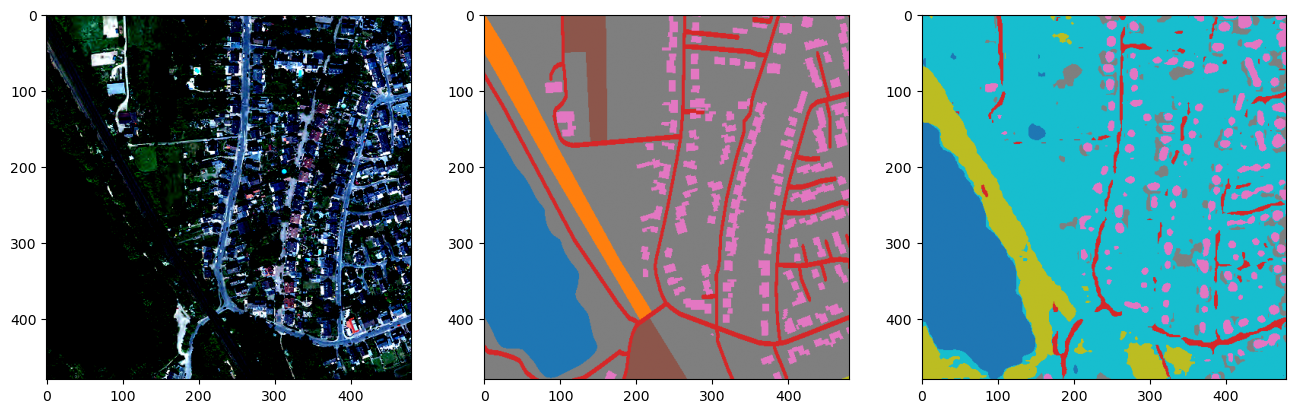

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
i = 0

ax[0].imshow(imgs[i].permute(1, 2, 0))
ax[1].imshow(seg2rgb(masks[i, 0]))
ax[2].imshow(seg2rgb(output[i].argmax(0)))
plt.show()

Made some addition, so you can your pictures here

Uncomment below code if you want to use your picture

In [13]:
# a = Image.open("PUT_UR_IMAGE_HERE").convert('RGB')
# a=a.resize((1168, 672))
# a

In [14]:
# from torchvision import transforms
# convert_tensor = transforms.ToTensor()
# bbb = convert_tensor(a)

In [15]:
# some_output = model.predict(bbb.reshape(1,3, 1168, 672).to(DEVICE)).to('cpu')

In [16]:
# fig, ax = plt.subplots(1, 2, figsize=(16, 5))
# i = 0
# ax[0].imshow(a)
# ax[1].imshow(seg2rgb(some_output[i].argmax(0)))
# plt.show()

## We can try to do it another way. Let's see how

In [17]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null -q
import segmentation_models_pytorch.utils as smp_utils

import segmentation_models_pytorch as smp
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook


This code is used to create a dataframe called `meta_df` that contains information about satellite images and their corresponding masks. 

First, the code defines the directory where the data is located (`DATA_DIR`) and the folders for training and validation (`train_folders` and `val_folders`).

Then, the code initializes empty lists to store the paths of the satellite images (`all_imgs`), the paths of the masks (`all_masks`), and the split (either "train" or "validation") for each image (`all_split`).

Next, the code iterates over each folder in the combined list of `train_folders` and `val_folders`. For each folder, it determines whether it is a training folder or a validation folder based on whether it is in the `train_folders` list. It assigns the appropriate split value ("train" or "validation") to the `split` variable.

The code then constructs the full path to the folder by joining the `DATA_DIR` and the current folder. It retrieves a list of files in the folder and filters it to only include files that contain "rgb" in their name. It constructs the paths to the corresponding masks by replacing "_rgb.jp2" with "_seg.tif" in each file path.

Next, the code creates a list of split values, where each value is equal to the `split` variable. This list has the same length as the number of files in the folder.

Finally, the code extends the `all_imgs`, `all_split`, and `all_masks` lists with the file paths, split values, and mask paths, respectively.

After the loop, the code creates a pandas DataFrame called `meta_df` using the `all_imgs` list as the "sat_image_path" column, the `all_masks` list as the "mask_path" column, and the `all_split` list as the "split" column.

The code then samples 5 random rows from the `meta_df` DataFrame and displays them.

In [18]:
DATA_DIR = '../input/geonrw/data/'
train_folders = ['aachen', 'bergisch', 'bielefeld', 'bochum', 'bonn', 'erftstadt']#TRAIN_DIRS #['aachen', 'bergisch', 'bielefeld', 'bochum', 'bonn', 'erftstadt']
val_folders = ['lotte', 'duisburg']#VALID_DIRS #['lotte', 'duisburg']

all_imgs = []
all_masks = []
all_split = []
for folder in train_folders + val_folders:
    classes = folder in train_folders
    split = "train" if classes else "validation"
    
    folder_path = os.path.join(DATA_DIR, folder)
    files = os.listdir(folder_path)
    files = [os.path.join(folder_path, i) for i in files if "rgb" in i]
    masks = [i.replace("_rgb.jp2", "_seg.tif") for i in files]
    
    classes = [split for _ in files]
    
    all_imgs.extend(files)
    all_split.extend(classes)
    all_masks.extend(masks)
    
meta_df = pd.DataFrame(all_imgs, columns=["sat_image_path"])
meta_df["mask_path"] = all_masks
meta_df["split"] = all_split

meta_df.sample(5)

,sat_image_path,mask_path,split
1410,../input/geonrw/data/duisburg/340_5689_rgb.jp2,../input/geonrw/data/duisburg/340_5689_seg.tif,validation
1373,../input/geonrw/data/duisburg/343_5697_rgb.jp2,../input/geonrw/data/duisburg/343_5697_seg.tif,validation
550,../input/geonrw/data/bielefeld/462_5755_rgb.jp2,../input/geonrw/data/bielefeld/462_5755_seg.tif,train
1299,../input/geonrw/data/duisburg/345_5693_rgb.jp2,../input/geonrw/data/duisburg/345_5693_seg.tif,validation
760,../input/geonrw/data/bochum/378_5699_rgb.jp2,../input/geonrw/data/bochum/378_5699_seg.tif,train


In [19]:
train_df = meta_df[meta_df['split']=='train'][['sat_image_path', 'mask_path']]
valid_df = meta_df[meta_df['split']=='validation'][['sat_image_path', 'mask_path']]

# Shuffle DataFrame
train_df = train_df.sample(frac=1).reset_index(drop=True)

len(train_df), len(valid_df)

(1192, 373)

In [20]:
# Get class names
class_names = ['unknown', 'forest', 'water', 'agricultural', 'urban',
               'grassland', 'railway', 'highway', 'airports_shipyards',
                'roads', 'buildings']

# Get class RGB values
class_rgb_values = [
    [0, 0, 0],
    [1, 1, 1],
    [2, 2, 2],
    [3, 3, 3],
    [4, 4, 4],
    [5, 5, 5],
    [6, 6, 6],
    [7, 7, 7],
    [8, 8, 8],
    [9, 9, 9],
    [10, 10,10],
]  

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['unknown', 'forest', 'water', 'agricultural', 'urban', 'grassland', 'railway', 'highway', 'airports_shipyards', 'roads', 'buildings']
Class RGB values:  [[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4], [5, 5, 5], [6, 6, 6], [7, 7, 7], [8, 8, 8], [9, 9, 9], [10, 10, 10]]


In [21]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['unknown', 'forest', 'water', 'agricultural', 'urban',
               'grassland', 'railway', 'highway', 'airports_shipyards',
                'roads', 'buildings']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['unknown', 'forest', 'water', 'agricultural', 'urban', 'grassland', 'railway', 'highway', 'airports_shipyards', 'roads', 'buildings']
Class RGB values:  [[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4], [5, 5, 5], [6, 6, 6], [7, 7, 7], [8, 8, 8], [9, 9, 9], [10, 10, 10]]


In [22]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

This code defines a custom dataset class called `LandCoverDataset` that is used to read images and masks, apply augmentation and preprocessing transformations.

The class takes several arguments:
- `df`: a DataFrame containing the paths to the satellite images and corresponding masks.
- `class_rgb_values`: a list of RGB values of select classes to extract from the segmentation mask.
- `augmentation`: an augmentation pipeline that can be applied to the images and masks.
- `preprocessing`: a preprocessing pipeline that can be applied to the images and masks.

In the `__init__` method, the image and mask paths are extracted from the DataFrame and stored as attributes of the class. The `class_rgb_values`, `augmentation`, and `preprocessing` arguments are also stored as attributes.

The `__getitem__` method is used to retrieve an item from the dataset. It takes an index `i` as input and returns the corresponding image and mask. 

Inside the `__getitem__` method, the image and mask are read using OpenCV's `cv2.imread` function. The image is then converted from BGR to RGB color space using `cv2.cvtColor`. 

The mask is one-hot encoded using a function called `one_hot_encode`, which takes the mask and the class RGB values as input and returns a one-hot encoded mask. The resulting mask is then cast to the 'float' data type.

If an augmentation pipeline is provided, it is applied to the image and mask using the `augmentation` method of the pipeline. The resulting augmented image and mask are then assigned to the `image` and `mask` variables.

If a preprocessing pipeline is provided, it is applied to the image and mask using the `preprocessing` method of the pipeline. The resulting preprocessed image and mask are then assigned to the `image` and `mask` variables.

Finally, the `image` and `mask` are returned as the output of the `__getitem__` method.

The `__len__` method returns the length of the dataset, which is the number of image paths stored in the `image_paths` attribute.

In [23]:
class LandCoverDataset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [24]:
preferred_class_rgb_values = [
    (0, 0, 0),        # black for unknown
    (44, 160, 44),    # green for forest
    (31, 119, 180),   # blue for water
    (140, 86, 75),    # brown for agricultural
    (127, 127, 127),  # gray urban
    (188, 189, 34),   # olive for grassland
    (255, 127, 14),   # orange for railway
    (148, 103, 189),  # purple for highway
    (23, 190, 207),   # cyan for airports and shipyards
    (214, 39, 40),    # red for roads
    (227, 119, 194),  # pink for buildings 
]

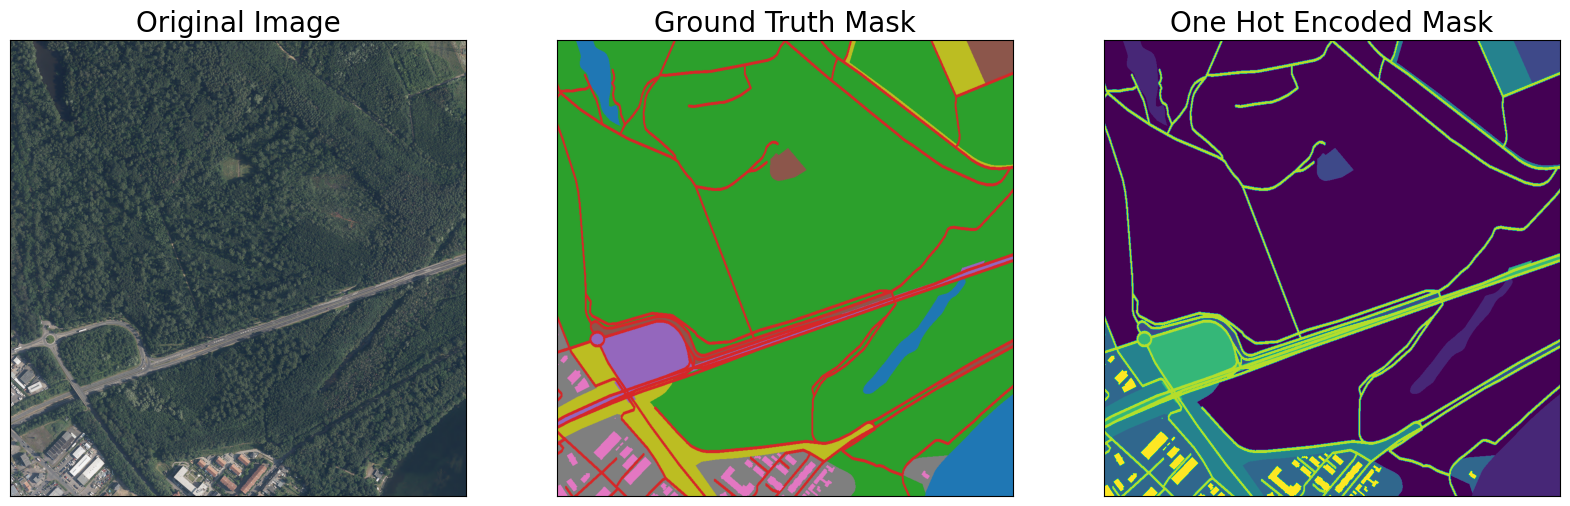

In [25]:
dataset = LandCoverDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), preferred_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

The `get_training_augmentation` function returns a composition of augmentation transforms to be applied during training. The transforms include random cropping, horizontal flipping, and vertical flipping. The `RandomCrop` transform randomly crops the input image to a specified height and width. The `HorizontalFlip` transform randomly flips the input image horizontally with a probability of 0.5. The `VerticalFlip` transform randomly flips the input image vertically with a probability of 0.5. The `always_apply=True` argument ensures that these transforms are always applied.

The `get_validation_augmentation` function returns a composition of augmentation transforms to be applied during validation. The transform includes center cropping, which crops the input image to a specified height and width. The `always_apply=True` argument ensures that this transform is always applied.

The `to_tensor` function converts the input image to a tensor format. It transposes the dimensions of the image array to match the expected format for neural networks (channels, height, width). It also converts the image array to the `float32` data type.

The `get_preprocessing` function constructs a preprocessing transform. It takes an optional argument `preprocessing_fn`, which is a callable function for data normalization. If `preprocessing_fn` is provided, it is applied to the input image using the `Lambda` transform. The `to_tensor` function is also applied to both the image and mask using the `Lambda` transform. The resulting transforms are then composed using the `Compose` function from the `albumentations` library.

In [26]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=720, width=720, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=720, width=720, always_apply=True),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

First, an instance of `LandCoverDataset` is created with the `train_df` dataframe as input. The `augmentation` parameter is set to `get_training_augmentation()`, which is a function that returns a set of augmentation transformations to be applied to the dataset. The `class_rgb_values` parameter is set to `select_class_rgb_values`, which is a variable that contains the RGB values for each class in the dataset.

Next, a random index is generated using the `random.randint()` function. This index is used to select a random sample from the augmented dataset.

Then, a loop is executed three times, each time selecting a different image and mask pair from the augmented dataset. The `image` and `mask` variables store the selected image and mask pair.

Finally, the `visualize()` function is called with several parameters. The `original_image` parameter is set to the `image` variable, representing the original image from the dataset. The `ground_truth_mask` parameter is set to the result of applying the `colour_code_segmentation()` function to the `mask` variable. This function converts the one-hot encoded mask to a colored mask using the preferred RGB values for each class. The `one_hot_encoded_mask` parameter is set to the result of applying the `reverse_one_hot()` function to the `mask` variable. This function converts the one-hot encoded mask back to its original format.

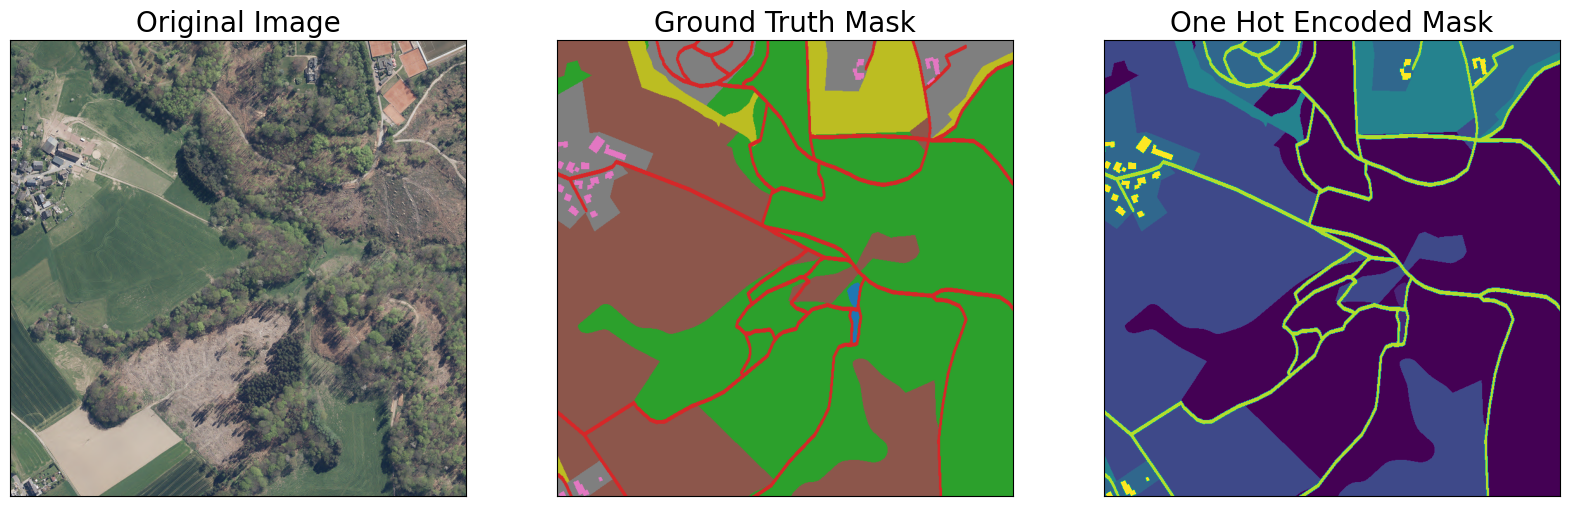

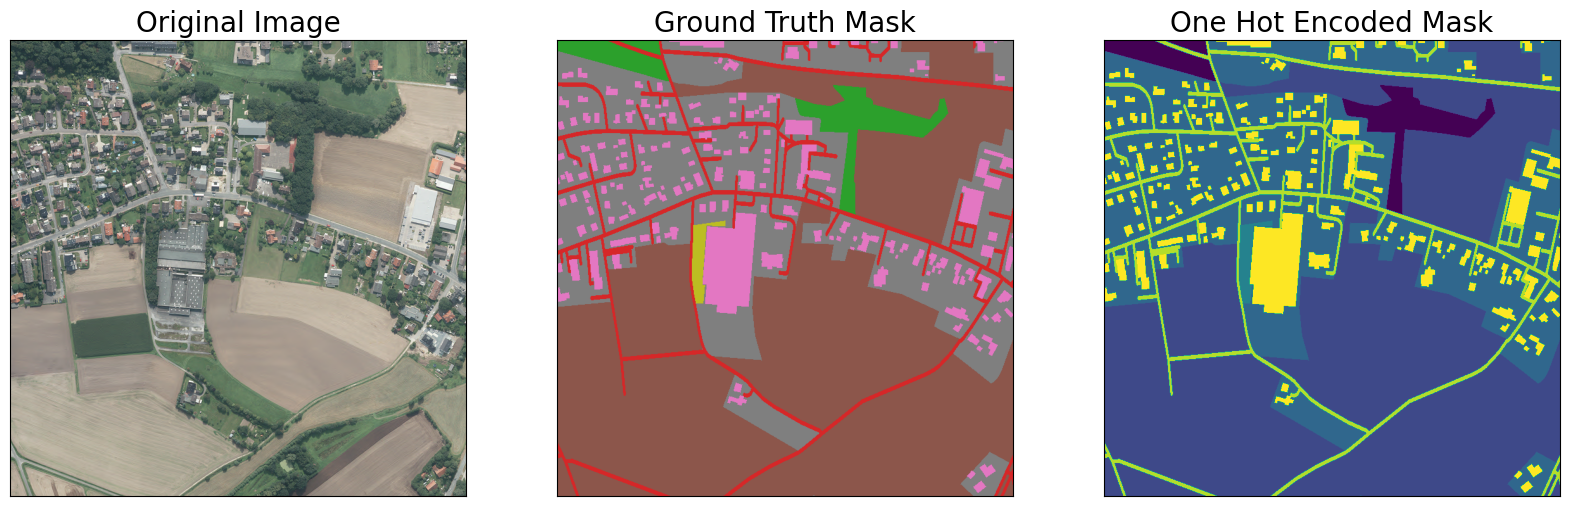

In [27]:
augmented_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(2):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), preferred_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

This code is creating a segmentation model using the DeepLabV3Plus architecture. The model is based on the ResNet50 encoder, which is a popular convolutional neural network architecture for image classification. The encoder weights are initialized with pre-trained weights from the ImageNet dataset.

The number of classes for the segmentation task is determined by the `select_classes` variable. The `len(CLASSES)` is used to set the number of output channels in the model.

The activation function used in the model is determined by the `ACTIVATION` variable. In this case, the activation function is set to 'sigmoid', which is commonly used for binary segmentation tasks. This means that the output of the model will be a probability map for each class, where each pixel represents the probability of that pixel belonging to the class.

The `smp.DeepLabV3Plus` function is used to create the segmentation model. It takes several arguments including the encoder name, encoder weights, number of classes, and activation function. This function initializes the model architecture and sets the weights of the encoder based on the specified parameters.

The `smp.encoders.get_preprocessing_fn` function is used to get the preprocessing function for the specified encoder. This function returns a function that can be used to preprocess input images before feeding them into the model. The preprocessing function is important because it ensures that the input images are in the correct format and range for the model.

Overall, this code sets up a segmentation model using the DeepLabV3Plus architecture with a ResNet50 encoder and pre-trained weights from ImageNet. It also sets the number of classes and activation function for the segmentation task, and gets the preprocessing function for the specified encoder.

In [28]:
ENCODER = 'resnet101' #timm-efficientnet-b8 -> eats all your memmory 
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
model= torch.nn.DataParallel(model) 
#model.to(DEVICE)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [29]:
# Get train and val dataset instances
train_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

In [30]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
        
# define loss function
loss = smp_utils.losses.DiceLoss()
#loss = smp.losses.DiceLoss('multiclass')
# define metrics
metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/satellite-segmentation-model/best_model.pth'):
    model = torch.load('../input/satellite-segmentation-model/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

In [31]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [32]:
import gc
gc.collect()

18166

In [33]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 373/373 [04:59<00:00,  1.24it/s, dice_loss - 0.7233, iou_score - 0.2643]
Model saved!

Epoch: 1
valid: 100%|██████████| 373/373 [04:59<00:00,  1.24it/s, dice_loss - 0.6537, iou_score - 0.3788]
Model saved!

Epoch: 2
valid: 100%|██████████| 373/373 [04:58<00:00,  1.25it/s, dice_loss - 0.6013, iou_score - 0.4174]
Model saved!

Epoch: 3
valid: 100%|██████████| 373/373 [04:56<00:00,  1.26it/s, dice_loss - 0.556, iou_score - 0.4275]
Model saved!

Epoch: 4
valid: 100%|██████████| 373/373 [04:52<00:00,  1.27it/s, dice_loss - 0.5129, iou_score - 0.4405]
Model saved!

Epoch: 5
valid: 100%|██████████| 373/373 [04:43<00:00,  1.31it/s, dice_loss - 0.4919, iou_score - 0.4397]

Epoch: 6
valid: 100%|██████████| 373/373 [04:45<00:00,  1.31it/s, dice_loss - 0.4539, iou_score - 0.4653]
Model saved!

Epoch: 7
valid: 100%|██████████| 373/373 [04:44<00:00,  1.31it/s, dice_loss - 0.445, iou_score - 0.465]
CPU times: user 12min 41s, sys: 2min 2s, total: 14min 43s
Wall time: 

In [34]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/satellite-segmentation-model/best_model.pth'):
    best_model = torch.load('../input/satellite-segmentation-model/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


This code snippet is used to create a test dataloader for the DeepLabV3+ model. The dataloader is responsible for loading and preprocessing the test dataset.

First, a `LandCoverDataset` object is created with the `valid_df` dataframe as input. The `valid_df` dataframe contains the validation dataset. The `augmentation` parameter is set to `get_validation_augmentation()`, which applies augmentation operations to the dataset. The `preprocessing` parameter is set to `get_preprocessing(preprocessing_fn)`, which applies preprocessing operations to the dataset. The `class_rgb_values` parameter is set to `select_class_rgb_values`, which specifies the RGB values for each class in the dataset.

Next, a dataloader is created using the `DataLoader` class. The `test_dataset` is passed as the input to the dataloader.

Then, another `LandCoverDataset` object is created for visualization purposes. This dataset does not include the preprocessing augmentations and transformations. It is created using the same parameters as the previous dataset.

A random index is generated using the `random.randint()` function to select a random image/mask pair from the visualization dataset.

Finally, the `visualize()` function is called with the original image, the ground truth mask, and the one-hot encoded mask as inputs. The `original_image` parameter is set to the `image` variable, which contains the original image. The `ground_truth_mask` parameter is set to the result of the `colour_code_segmentation()` function, which converts the one-hot encoded mask to a colored mask using the preferred class RGB values. The `one_hot_encoded_mask` parameter is set to the result of the `reverse_one_hot()` function, which converts the one-hot encoded mask back to its original format.

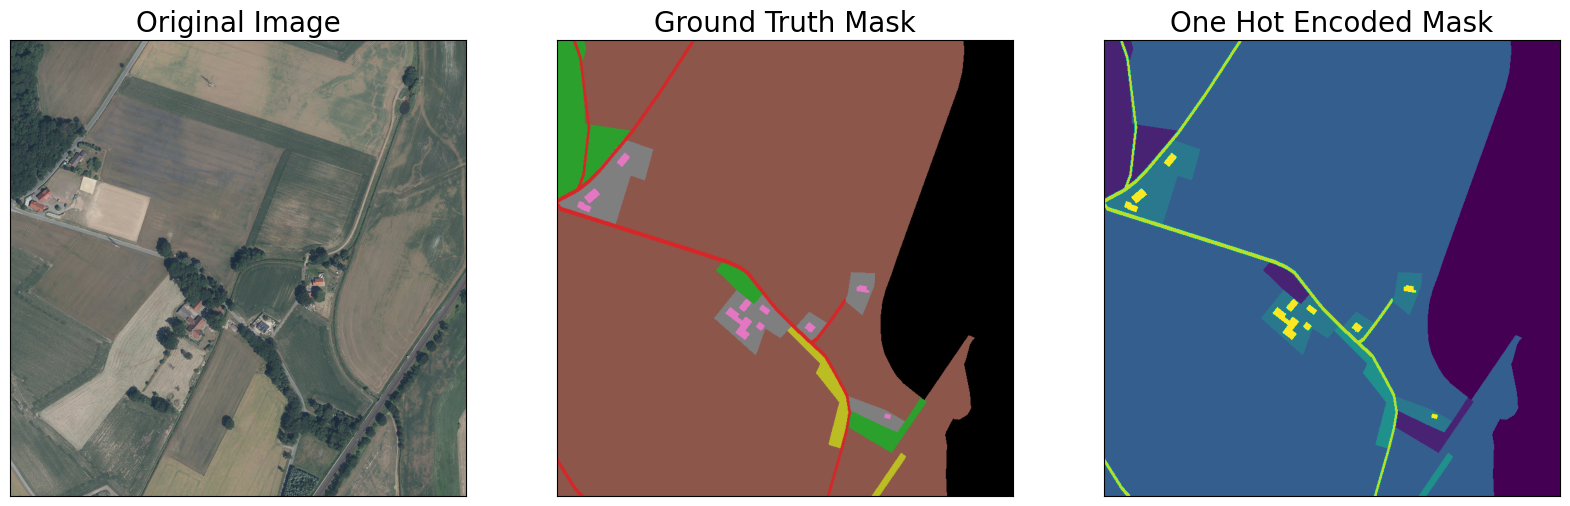

In [35]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), preferred_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [36]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

This code is calculating the class-wise dice coefficient for a given set of true and predicted values. The dice coefficient is a metric commonly used in image segmentation tasks to measure the similarity between the predicted and true segmentation masks.

The code starts by initializing a list called `scores` with 10 elements, all set to 0. This list will store the dice coefficient for each class.

Next, there are two helper functions defined: `dice_coef` and `classwise_dice`.

The `dice_coef` function takes in two arrays, `y_true` and `y_pred`, which represent the true and predicted segmentation masks, respectively. The function first flattens both arrays using the `flatten` method, which converts the arrays into 1-dimensional arrays. Then, it calculates the element-wise multiplication of `y_true_f` and `y_pred_f` using the `*` operator and sums the result using `np.sum`. This gives the intersection between the true and predicted masks. 

A small value of `smooth` (0.0001) is added to the intersection to avoid division by zero. Finally, the dice coefficient is calculated by dividing the sum of the intersection and smooth by the sum of `y_true_f`, `y_pred_f`, and smooth, multiplied by 2.

The `classwise_dice` function takes in `y_true` and `y_pred` arrays, which represent the true and predicted segmentation masks for multiple classes. It also uses the `scores` list defined earlier.

The function iterates over the range from 1 to 11 (exclusive) using a `for` loop. This loop is used to calculate the dice coefficient for each class separately.

Inside the loop, two new arrays, `y_true1` and `y_pred1`, are created as copies of `y_true` and `y_pred`, respectively. Then, all elements in `y_true1` that are not equal to the current class `c` are set to 0, while all elements that are equal to `c` are set to 1. This creates a binary mask for the current class in `y_true1`.

Similarly, the same operations are performed on `y_pred1` to create a binary mask for the current class in `y_pred1`.

The `dice_coef` function is then called with `y_true1` and `y_pred1` as arguments to calculate the dice coefficient for the current class. The result is added to the corresponding element in the `scores` list using the `+=` operator.

After the loop finishes, the `scores` list is returned as the output of the `classwise_dice` function. This list contains the dice coefficient for each class, where the index of each element corresponds to the class number minus 1.

In [37]:
scores = [0] * 10

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def classwise_dice(y_true, y_pred):
    global scores
    for c in range(1, 11):
        y_true1 = y_true.copy()
        y_true1[y_true1 != c] = 0
        y_true1[y_true1 == c] = 1
        
        y_pred1 = y_pred.copy()
        y_pred1[y_pred1 != c] = 0
        y_pred1[y_pred1 == c] = 1
        
        scores[c-1] += dice_coef(y_true1, y_pred1)
    
    return scores

This code includes two functions: `rle_encode` and `rle_to_string`.

The `rle_encode` function takes a binary mask as input and returns the run-length encoding (RLE) of the mask. RLE is a simple compression algorithm that represents consecutive repeated values as a pair of numbers: the starting position and the length of the run. In this case, the RLE encoding is applied to the flattened transpose of the mask.

The function first checks if padding is needed by examining the first and last values of the flattened mask. If either of them is non-zero, padding is required. Padding is done by creating a new array with two additional elements and copying the original mask into the middle of the new array. This ensures that there is a zero at both ends of the sequence.

Next, the function calculates the RLE by finding the indices where the consecutive values change. This is done by comparing each element with its previous element and finding the indices where the values differ. The indices are then incremented by 2 to account for the padding.

If padding was used, the indices are adjusted by subtracting 1 to account for the padding.

Finally, the function calculates the lengths of the runs by subtracting consecutive indices. This is done by subtracting every other element from the previous element. The resulting RLE is returned.

The `rle_to_string` function takes a list of runs as input and returns a string representation of the runs. This is done by joining the elements of the list with a space delimiter using a list comprehension.

Overall, these functions provide a way to encode binary masks using the RLE algorithm and convert the resulting runs into a string representation.

In [38]:
# Used for creating submission csv with predictions.
def rle_encode(mask):
    pixels = mask.T.flatten()
    # We need to allow for cases where there is a '1' at either end of the sequence.
    # We do this by padding with a zero at each end when needed.
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

This code is a loop that iterates over a dataset of test images. It performs some operations on each image and then adds the results to a pandas DataFrame.

Here is a step-by-step explanation of the code:

1. Initialize a list called `scores` with 10 zeros. This list will be used later to store the results of the predictions for each class.

2. Create an empty pandas DataFrame called `output_df` with columns for the image name, height, width, and 10 different classes.

3. Start a loop that iterates over the indices of the `test_dataset`. The `tqdm_notebook` function is used to display a progress bar during the loop.

4. Inside the loop, get the image and ground truth mask for the current index from the `test_dataset`.

5. Convert the image to a tensor and move it to the specified device (e.g., GPU) using `torch.from_numpy` and `to(DEVICE)`.

6. Pass the image tensor to a model called `best_model` to get the predicted mask. Detach the tensor from the computation graph, squeeze it to remove any singleton dimensions, and convert it to a numpy array.

7. Transpose the predicted mask array from `CHW` format to `HWC` format.

8. Extract the prediction channel corresponding to the "urban" class from the predicted mask.

9. Convert the predicted mask to an image using the `colour_code_segmentation` function, which maps the class labels to RGB values.

10. Transpose the ground truth mask from `CHW` format to `HWC` format.

11. Reverse the one-hot encoding of the predicted mask to get the class labels.

12. Extract the file name from the image path.

13. Create an empty list called `lst` to store the RLE-encoded masks for each class.

14. Start a loop that iterates over the class indices from 1 to 10 (excluding 0, which represents the background class).

15. Create a copy of the predicted mask array and set all pixels that do not belong to the current class to 0, and set all pixels that belong to the current class to 1.

16. Encode the binary mask using the RLE encoding algorithm and convert it to a string.

17. Append the RLE-encoded mask string to the `lst` list.

18. Create a new row for the `output_df` DataFrame with the file name, height, width, and the RLE-encoded masks for each class.

19. Concatenate the new row with the existing rows of the `output_df` DataFrame and reset the index.

20. Repeat the loop for the next image in the `test_dataset`.

At the end of the loop, the `output_df` DataFrame will contain the results of the predictions for each image in the test dataset, with the RLE-encoded masks for each class.

In [39]:
scores = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
output_df = pd.DataFrame(columns=['name','height','width', 'forest', 'water', 'agricultural', 'urban', 'grassland', 'railway', 'highway', 'airports and shipyards', 'roads', 'buildings'])
for idx in tqdm_notebook(range(len(test_dataset))):
    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_urban_land_heatmap = pred_mask[:,:,select_classes.index('urban')]
    pred_mask_img = colour_code_segmentation(reverse_one_hot(pred_mask), preferred_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    
    y_pred = reverse_one_hot(pred_mask)
    
    file_name = "/".join(test_dataset.image_paths[idx].split("/")[-2:])

    lst = []
    # gt_maskı classwise yap
    for c in range(1, 11):

        y_pred1 = y_pred.copy()
        y_pred1[y_pred1 != c] = 0
        y_pred1[y_pred1 == c] = 1
        # rle encode et, dfye ekle
        lst.append(rle_to_string(rle_encode(y_pred1)))

    new_row = pd.DataFrame({'name':file_name, 'height':720, 'width':720, 'forest':lst[0], 'water':lst[1], 'agricultural':lst[2], 'urban':lst[3], 'grassland':lst[4], 'railway':lst[5], 'highway':lst[6], 'airports and shipyards':lst[7], 'roads':lst[8], 'buildings':lst[9]}, index=[0])

    output_df = pd.concat([new_row, output_df.loc[:]]).reset_index(drop=True)
        

  0%|          | 0/373 [00:00<?, ?it/s]

In [40]:
output_df.to_csv('output.csv', index=False, sep='|')

In [41]:
output_df = pd.read_csv('./output.csv', sep='|')

In [42]:
import json

scores_dict = dict(
    zip(select_classes[1:], [sc / len(test_dataset) for sc in scores])
)

with open("scores.txt", "w") as f:
    f.write(json.dumps(scores_dict))
scores_dict

{'forest': 0.0,
 'water': 0.0,
 'agricultural': 0.0,
 'urban': 0.0,
 'grassland': 0.0,
 'railway': 0.0,
 'highway': 0.0,
 'airports_shipyards': 0.0,
 'roads': 0.0,
 'buildings': 0.0}

In [43]:
def predict(test_images, test_masks, trained_model):
    # Read model
    # load best saved model checkpoint from previous commit (if present)
    if os.path.exists(trained_model):
        best_model = torch.load(trained_model, map_location=DEVICE)
        print('Loaded model')

    test_df = pd.DataFrame()
    test_df["sat_image_path"] = test_images
    test_df["mask_path"] = test_masks

    test_dataset = LandCoverDataset(
    test_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
    )

    # Get train and val data loaders
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

    scores = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    output_df = pd.DataFrame(columns=['name','height','width', 'forest', 'water', 'agricultural', 'urban', 'grassland', 'railway', 'highway', 'airports and shipyards', 'roads', 'buildings'])

    for idx in tqdm_notebook(range(len(test_dataset))):
        image, gt_mask = test_dataset[idx]
        image_vis = test_dataset_vis[idx][0].astype('uint8')
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        # Predict test image
        pred_mask = best_model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        pred_mask = np.transpose(pred_mask,(1,2,0))
        # Convert gt_mask from `CHW` format to `HWC` format
        gt_mask = np.transpose(gt_mask,(1,2,0))

        y_pred = reverse_one_hot(pred_mask)

        file_name = "/".join(test_dataset.image_paths[idx].split("/")[-2:])

        lst = []
        # gt_maskı classwise yap
        for c in range(1, 11):

            y_pred1 = y_pred.copy()
            y_pred1[y_pred1 != c] = 0
            y_pred1[y_pred1 == c] = 1
            # rle encode et, dfye ekle
            lst.append(rle_to_string(rle_encode(y_pred1)))

        new_row = pd.DataFrame({'name':file_name, 'height':720, 'width':720, 'forest':lst[0], 'water':lst[1], 'agricultural':lst[2], 'urban':lst[3], 'grassland':lst[4], 'railway':lst[5], 'highway':lst[6], 'airports and shipyards':lst[7], 'roads':lst[8], 'buildings':lst[9]}, index=[0])

        output_df = pd.concat([new_row, output_df.loc[:]]).reset_index(drop=True)


    scores_dict = dict(
        zip(select_classes[1:], [sc / len(test_dataset) for sc in scores])
    )

    k = list(scores_dict.keys())
    sc_df = pd.DataFrame(columns=k)
    sc_df = sc_df.append(scores_dict, ignore_index=True)

    sc_df.to_csv("scores.txt", index=False)

    output_df.to_csv('output.csv', index=False)

In [44]:
predict(["../input/geonrw/data/aachen/286_5630_rgb.jp2"], ["../input/geonrw/data/aachen/286_5630_seg.tif"], "./best_model.pth")

Loaded model


  0%|          | 0/1 [00:00<?, ?it/s]